# Final Report
## Classifying Heart Disease by Age, Cholestrol levels and ST Depression
### Brian Moniaga, Floria Lu, Owen Yu, Jay Leyton High

# Introduction
In this project, we are predicting the likelihood of an individual to have heart disease based on their age, cholesterol levels, and ST depression induced by exercise relative to rest. 
Heart disease refers to various conditions that affect the heart, including diseases related to the blood vessel, heartbeat frequency, heart muscles and heart valve. Most of the conditions can be prevented or treated with lifestyle changes. Anatomically, they are caused by atherosclerosis, the build-up of fatty deposit in the walls of the coronary arteries.
Accordingly, age and the likelihood of having a heart disease have a positive correlation as aging can cause changes to the blood vessels and heart. Cholesterol is a lipid that provides vital functions to the cells in the body, but high cholesterol level can create the fatty deposit. Lastly, ST depression refers to the findings on an electrocardiogram. A valid ECG finding for the identification of obstructive coronary atherosclerosis is exercise-induced ST segment depression. It has been linked to heart diseases.
The dataset that we are using is the Hungarian data, collected on March 15, 1990, reprocessed on July 23, 1996. The database originally contains 76 attributes, but all published experiments refer to using a subset of 14. 

# Preliminary exploratory data analysis

### Preprocessing Data
Importing libraries and specifying plot format

In [1]:
# Loading libraries
library(tidymodels)
library(tidyverse)
library(cowplot)

# Plot format
options(repr.matrix.max.rows = 6)

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ recipes      1.0.1
✔ dials        1.0.0     ✔ rsample      1.0.0
✔ dplyr        1.0.9     ✔ tibble       3.1.7
✔ ggplot2      3.3.6     ✔ tidyr        1.2.0
✔ infer        1.0.2     ✔ tune         1.0.0
✔ modeldata    1.0.0     ✔ workflows    1.0.0
✔ parsnip      1.0.0     ✔ workflowsets 1.0.0
✔ purrr        0.3.4     ✔ yardstick    1.0.0

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Dig deeper into tidy modeling with R at https://www.tmwr.org

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ readr   2.1.2     ✔ forcats 0.5.1
✔ stringr 1.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() 

### Loading the dataset
Here we read our data using `read_delim()` as well as setting its column names accordingly

In [2]:
heart_all_data <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/reprocessed.hungarian.data", delim=" ",
                  col_names = c("age", "sex", "cp", "trestbps", "chol", 
                              "fbs", "restecg", "thalach", "exang", 
                              "oldpeak", "slope", "ca", "thal", 
                              "num"))
heart_all_data

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: " "
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
40,1,2,140,289,0,0,172,0,0,-9,-9,-9,0
49,0,3,160,180,0,0,156,0,1,2,-9,-9,1
37,1,2,130,283,0,1,98,0,0,-9,-9,-9,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,1,3,110,211,0,0,138,0,0,-9,-9,6,0
47,0,2,140,257,0,0,135,0,1,1,-9,-9,0
53,1,4,130,182,0,0,148,0,0,-9,-9,-9,0


Figure 1: This figure shows the data from the UCI database with the appropriate column names

### Cleaning data
After loading our data, we can see that some columns have different datatypes than what is stated from the website, we will proceed to clean these column. Moreover, we will also create a new column called diag where the the value `TRUE` means patient has a heart disease and `FALSE` otherwise.

In [3]:
heart_data <- heart_all_data |>
              select(age, oldpeak, chol, num) |>
              mutate(diag = as.factor(case_when(num>=1 ~ TRUE,
                                    TRUE ~ FALSE))) |>
              mutate(age = as.integer(age), oldpeak = as.double(oldpeak), chol = as.integer(chol), num = as.factor(num))
heart_data

age,oldpeak,chol,num,diag
<int>,<dbl>,<int>,<fct>,<fct>
40,0,289,0,FALSE
49,1,180,1,TRUE
37,0,283,0,FALSE
⋮,⋮,⋮,⋮,⋮
48,0,211,0,FALSE
47,1,257,0,FALSE
53,0,182,0,FALSE


Figure 2: This figure shows the column names that we are interested in. It also has an additional column called diag which shows the diagnosis, either positive (TRUE) or negative (FALSE) for heart disease.

### Splitting our data
After our data is clean and we have selected the columns that we care about we can start by splitting our data into testing and training. To make sure the split is reproducible we use `set.seed(2022)` and split our data into 75% training and 25% testing. We would also like for our data to be split according to the `diag` column so that we have a relatively equal proportion when splitting.

In [6]:
set.seed(2022)
heart_split <- initial_split(heart_data, prop = 0.75, strata = diag)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

### Details about our data
Now that our data is split, let's take a look at a summary of our training data by using `summary()` which will show us details about our data

In [7]:
summary(heart_training)

      age           oldpeak            chol       num        diag    
 Min.   :29.00   Min.   :0.0000   Min.   : -9.0   0:141   FALSE:141  
 1st Qu.:42.00   1st Qu.:0.0000   1st Qu.:197.5   1: 27   TRUE : 79  
 Median :49.00   Median :0.0000   Median :235.5   2: 20              
 Mean   :47.73   Mean   :0.5627   Mean   :231.5   3: 20              
 3rd Qu.:54.00   3rd Qu.:1.0000   3rd Qu.:280.2   4: 12              
 Max.   :65.00   Max.   :5.0000   Max.   :603.0                      

Figure 3: Based on this figure we can see some details about our data.

In figure 3, we can see several interesting facts about our training data specifically:
- The age column spans from 29 - 65 years old, and the average is about 47 years old
- The oldpeak column has an average of 0.5627
- The average cholestrol level is 231.5
- Our training data contains 79 patients with a heart disease and 141 with no heart disease

### Proportion of patients
Here we will take a look at the proportion of patients diagnosis within our data. This process will allow us to understand more about our data which will be useful when modelling.

In [8]:
proportion <- heart_training |>
            count(diag) |>
            mutate(proportions = n/nrow(heart_training))

proportion

diag,n,proportions
<fct>,<int>,<dbl>
FALSE,141,0.6409091
TRUE,79,0.3590909


Figure 4: The proportion of patients that are diagnosed with a heart disease

Figure 4 shows that about 35.9% of our data are patients diagnosed with a heart disease, while around 64% does not have a heart disease. Although ideally it would be better to have a 50/50 proportion, these proportion are good enough to train a model with. However, it might mean that our model will tend to diagnose patients with false negatives.

## Visualizing our data
In this step we will try to understand more about our dataset by visualizing it.

Firstly, in this part we will visualize the distribution of age between patients diagnosed with a heart disease and those who are not diagnosed. This part will help us understand the age group of patients that are diagnosed with a heart disease

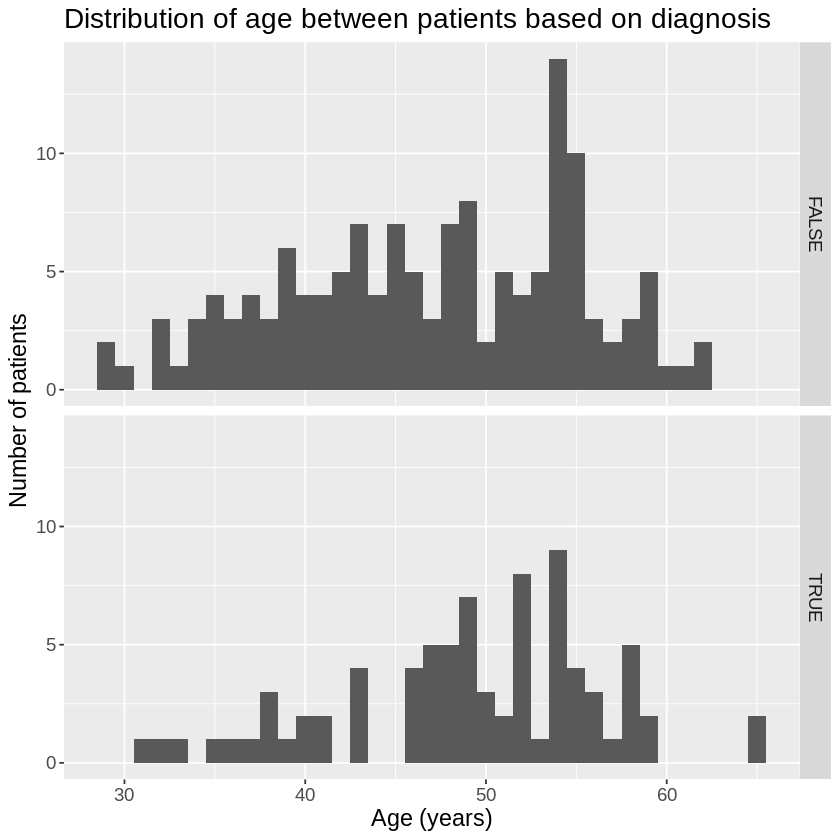

In [43]:
age_dist <- ggplot(heart_training) +
            geom_histogram(aes(x = age), binwidth = 1)+
            facet_grid(diag~.) +
            labs(x = "Age (years)", y = "Number of patients") +
            ggtitle("Distribution of age between patients based on diagnosis") +
            theme(text = element_text(size = 14))
age_dist

Figure 5: Distribution between patients that are not diagnosed with a heart disease and those diagnosed with a heart disease

From figure 5, we see that the distribution of age for both groups are similar. This visualization might suggest that age might be not a good predictor in finding patients who are diagnosed with a heart disease. In the next step, we will visualize the other predictors' average value by grouping them based on their diagnosis.

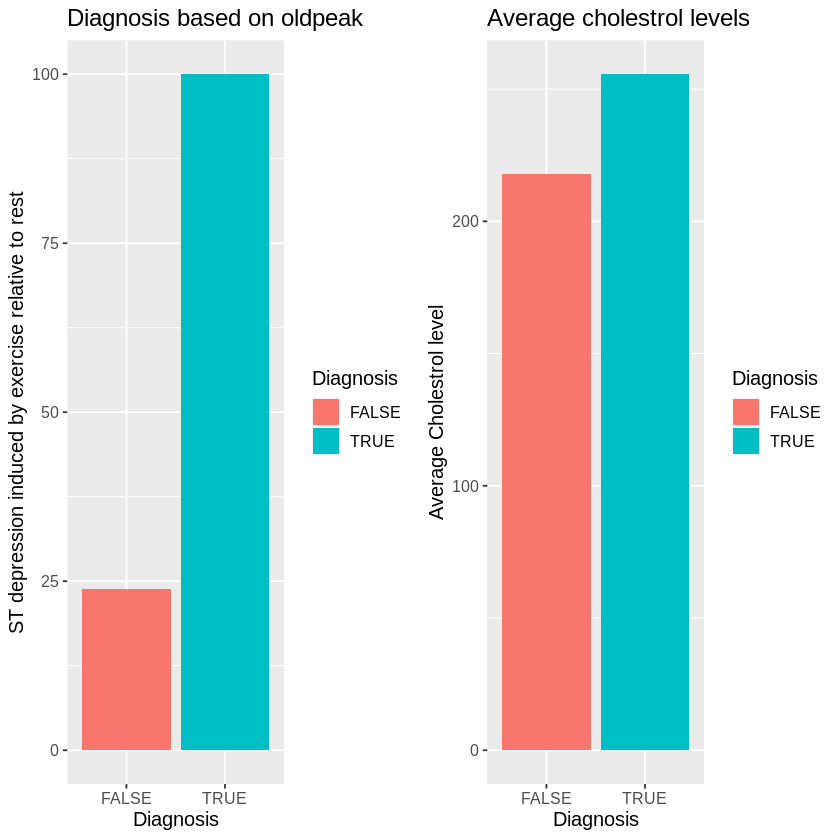

In [44]:
oldpeak_diag_dist <- heart_training |>
             ggplot(aes(x=diag, y=oldpeak, fill=diag)) +
             geom_bar(stat = "identity") +
             labs(x = "Diagnosis",
                  y = "ST depression induced by exercise relative to rest",
                  fill = "Diagnosis") +
             theme(text = element_text(size = 12)) +
             ggtitle("Diagnosis based on oldpeak")
chol_data <- heart_training |>
             group_by(diag) |>
             summarise(chol_avg = mean(chol))
chol_diag <- chol_data |>
             ggplot(aes(x=diag, y=chol_avg, fill = diag)) +
             geom_bar(stat = "identity") +
             labs(x = "Diagnosis",
                  y = "Average Cholestrol level",
                  fill = "Diagnosis") +
             ggtitle("Average cholestrol levels") +
             theme(text = element_text(size = 12))
plot_grid(oldpeak_diag_dist, chol_diag)

Figure 6: Based on the figure above, average value of oldpeak, and cholestrol levels grouped by diagnosis of patients.

In figure 6, we can see that `oldpeak` is a strong predictor that we can use for our model. Moreover, the average cholestrol level for patients that are diagnosed with a heart disease is higher than the group of patients that were not diagnosed. This might also suggest that `chol` might be a good predictor to use, however not as strong as `oldpeak`

# Methods
To predict if a patient has a heart disease, we will create a KNN model with `age`, `chol` (serum cholesterol), `oldpeak` (ST depression induced by exercise relative to rest) as our predictors. We will use these values to predict `diag` using KNN.  

Classification is the method of predicting a categorical class for an observation given its other variables. Based on how similar an observation is to other observations for which we do know the class, a classifier assigns an observation with an unknown class to a class. These observations with known classes that we use as a basis for prediction are called a training set. We call them a “training set” because we use these observations to train, or teach, our classifier so that we can use it to make predictions on new data that we have not seen previously. There are many possible methods for using classification but we are using the K-nearest neighbour algorithm. To classify a new observation, we calculate the distance between a new observation and each observation in the training set, sort the data table in ascending order based on the distances, select the top K rows of the sorted table, and classify the new observation based on a majority vote of the neighbour classes.   

To determine the value of K to be used in the model, we will perform a 6-fold cross-validation: R splits our training data into six “folds” of equal size and then uses each fold in turn as a set of training data to be tested against the other folds. We run a version of our model, tuning (as opposed to fitting) to the results of the cross-validation and finally selecting the best value of K based on the accuracy metrics returned by the `collect_metrics` function.  

We start by setting a seed which determines the "randomness" in how our data will be randomly split into six folds. Then, we perform the fold.

In [11]:
set.seed(1)

heart_vfold <- vfold_cv(heart_training, v = 6, strata = diag)

Next, we standardize the data to ensure that one predictor will not affect the model more than the others.

In [12]:
heart_recipe <- recipe(diag ~ age + oldpeak + chol, data = heart_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

Here, we create a table of potential K values (1-25) to be tested, as well as set up the KNN classification engine. The argument `neighbors = tune()` is specified, as we will use this engine to test our variety of K values before selecting one for the final model.

In [13]:
gridvals <- tibble(neighbors = seq(1, 25))

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

PLACEHOLDER

In [14]:
set.seed(2022)
knn_results <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heart_vfold, grid = gridvals) |>
  collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")
accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6917180,6,0.02565064,Preprocessor1_Model01
2,accuracy,binary,0.6917180,6,0.02565064,Preprocessor1_Model02
3,accuracy,binary,0.7135227,6,0.02621349,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
23,accuracy,binary,0.7951241,6,0.02051370,Preprocessor1_Model23
24,accuracy,binary,0.7951241,6,0.02051370,Preprocessor1_Model24
25,accuracy,binary,0.7951241,6,0.01632455,Preprocessor1_Model25


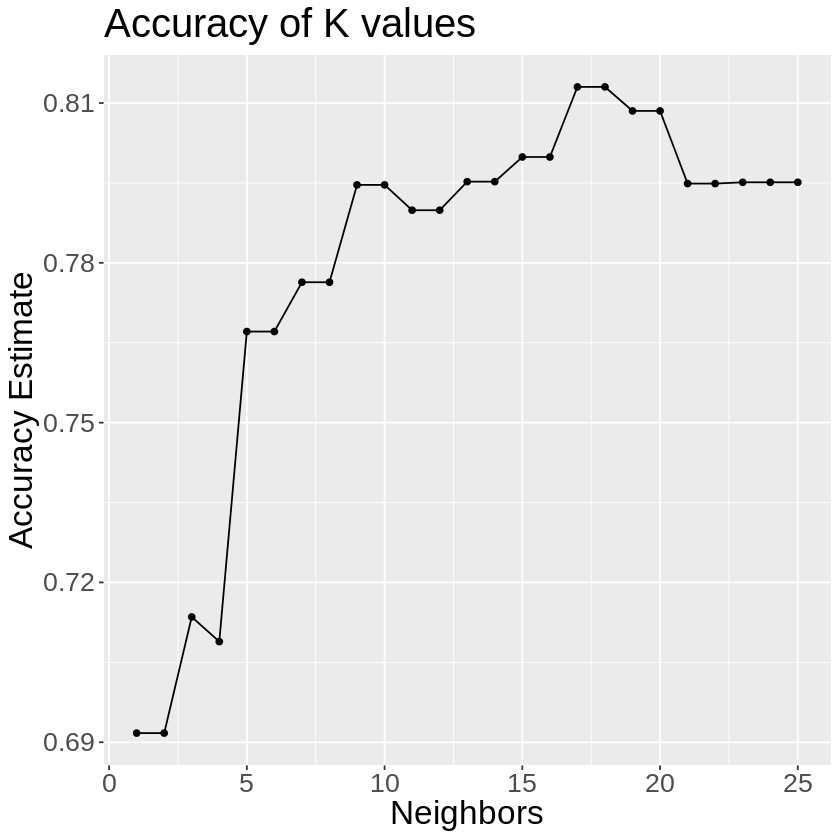

In [47]:
# Plot of k values against their respective accuracies
cross_val_plot <- accuracies |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle("Accuracy of K values") +
    theme(text = element_text(size = 20))
cross_val_plot

From the above plot, we select our K value of 17. Subsequently, we set up a new classification engine to make predictions based on the 17 nearest neighbor points. We then create a workflow, combining the recipe from previous steps and our new engine, and fitting to the data. 

In [17]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_best_spec) |>
  fit(data = heart_training)

We are finally ready to use our model to make predictions. To analyze the accuracy of our predictions against the actual diagnoses, we both calculate the percent accuracy and create a confusion matrix to show which types of errors our model made. 

In [18]:
heart_predictions <- predict(heart_fit, heart_testing) |> 
    bind_cols(heart_testing)

# Compare the accuracy of predictions to the true values in the test set
heart_acc <- heart_predictions |> 
    metrics(truth = diag, estimate = .pred_class) |> 
    select(.metric, .estimate) |> 
    head(1)

# Compare the predictions to the true values in a confusion matrix
heart_cm <- heart_predictions |> 
    conf_mat(truth = diag, estimate = .pred_class)

In [19]:
heart_acc

.metric,.estimate
<chr>,<dbl>
accuracy,0.7027027


This indicates our model was able to correctly predict a patient's heart disease diagnosis (or lack thereof) approximately 70.27% of the time. 

In [20]:
heart_cm

          Truth
Prediction FALSE TRUE
     FALSE    36   11
     TRUE     11   16

From the confusion matrix generated above, we can determine that our model was able to predict a total of 52 diagnoses correctly and 22 incorrectly. We also see it returned an equal number of Type I errors (false positives) and Type II errors (false negatives). The figure means that from 74 given patients our model was able to successfully diagnose 16 patients with a heart disease, it was also successful in identifying 36 patients without a heart disease. However our model identified that 11 patients had a heart disease while in reality they do not. The model also identified 11 patients to be healthy, while in reality they have a heart disease